In [18]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import rioxarray as rxr

### 1. Data preparation

#### 1.1. Shape file

In [ ]:
# Cargar shapefile - Opción 1 (Windows)
shapefile_path = '../data/shape_file_distritos/DISTRITOS.shp'
gdf = gpd.read_file(shapefile_path)
gdf.head()

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.31710 -9.297..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."


In [ ]:
# Cargar shapefile - Opción 2 (Windows/macOS/Linux)
shapefile_path = os.path.join("..", "data", "shape_file_distritos", "DISTRITOS.shp")
gdf = gpd.read_file(shapefile_path)
gdf.head()

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.31710 -9.297..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."


#### 1.2. Raster file

In [14]:
# Ruta al archivo raster
raster_file = '../data/tmin_raster.tif'

# Abrir el archivo
with rasterio.open(raster_file) as src:
    print("Ancho:", src.width)
    print("Alto:", src.height)
    print("Número de bandas:", src.count)
    print("Sistema de coordenadas:", src.crs)
    print("Transformación (afín):", src.transform)

    # Bandas
    banda1 = src.read(1)
    banda2 = src.read(2)
    banda3 = src.read(3)
    banda4 = src.read(4)
    banda5 = src.read(5)

Ancho: 285
Alto: 397
Número de bandas: 5
Sistema de coordenadas: EPSG:4326
Transformación (afín): | 0.05, 0.00,-81.38|
| 0.00,-0.05, 1.20|
| 0.00, 0.00, 1.00|


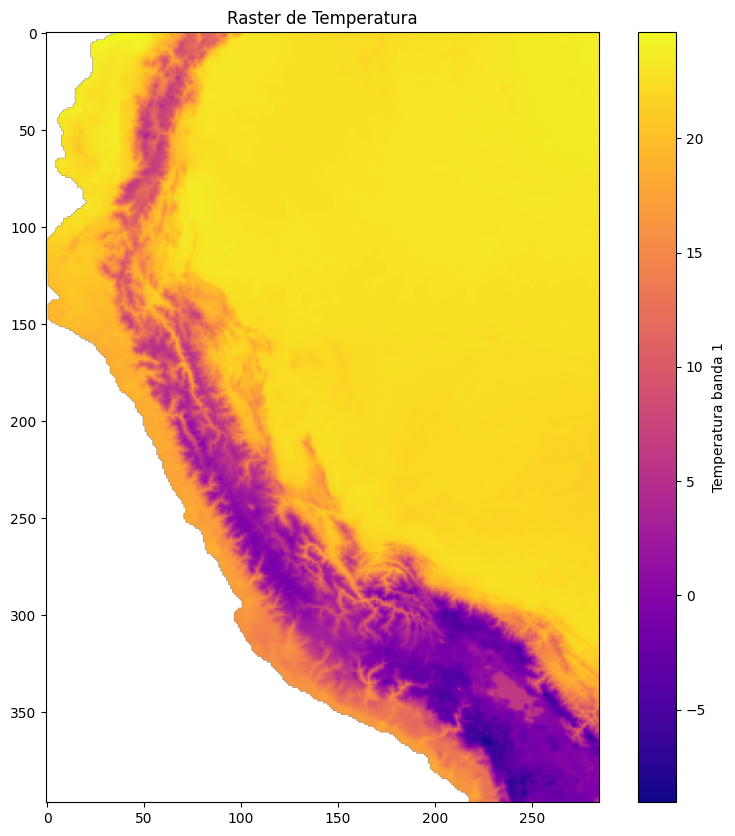

In [15]:
# Visualizamos la banda 1

plt.figure(figsize=(10, 10))
plt.imshow(banda1, cmap='plasma')
plt.colorbar(label='Temperatura banda 1')
plt.title("Raster de Temperatura")
plt.show()

#### 1.3. Cropping

In [28]:
# Reproyectar shapefile
with rasterio.open(raster_file) as src:       # Abrir el tfile de clasificación
    if gdf.crs != src.crs:                    # Si el sistema de coordenadas es distinto...
        gdf = gdf.to_crs(src.crs)             # ... que adopte el sistema de coordenadas del rasterfile              

    # Recortar el raster usando el shapefile
    out_image, out_transform = mask(src, gdf.geometry, crop=True)   # Recorte en base a geometry de gdf
    out_meta = src.meta.copy()                                      # Copia de la metadata original

# Actualizar metadata para el nuevo raster recortado
out_meta.update({                    # Actualizo la copia de la metadata original con los parámetros del raster recortado
    "height": out_image.shape[1],    # altura
    "width": out_image.shape[2],     # ancho
    "transform": out_transform
})

# Guardar el nuevo raster recortado
with rasterio.open("../data/recorte.tif", "w", **out_meta) as dest:
    dest.write(out_image)

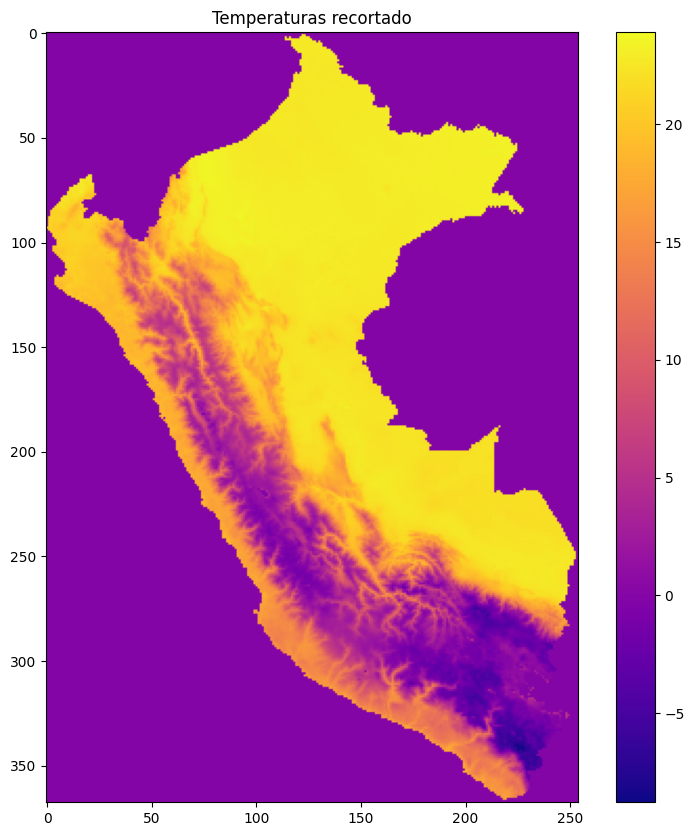

In [ ]:
# Visualizamos el recorte

plt.figure(figsize=(10, 10))
plt.imshow(out_image[0], cmap='plasma')
plt.title("Temperaturas recortado")
plt.colorbar()
plt.show()

### 2. Zonal statistics

#### 2.1. Rerescaling (if necessary)

In [19]:
# Cargar raster
da = rxr.open_rasterio(raster_file, masked=True)

# Ver estadísticos globales por banda (rápido chequeo)
for b in range(1, da.sizes["band"] + 1):
    vals = np.asarray(da.sel(band=b).values).ravel()
    vals = vals[np.isfinite(vals)]
    print(f"Banda {b}: min={vals.min():.2f}, max={vals.max():.2f}, mean={vals.mean():.2f}")

Banda 1: min=-9.05, max=24.64, mean=18.01
Banda 2: min=-10.02, max=24.39, mean=17.91
Banda 3: min=-9.87, max=24.21, mean=17.77
Banda 4: min=-9.06, max=24.12, mean=17.61
Banda 5: min=-8.85, max=24.15, mean=17.82


In [21]:
# Evaluar si necesita reescalamiento
# Criterio empírico para Tmin:
#     - Kelvin ≈ 250–320  →  restar 273.15
#     - Escalado ×10 ≈ 150–250  →  dividir entre 10
#     - Escalado ×100 ≈ 1500–2500  →  dividir entre 100
#     - Celsius normal ≈ -10–35  →  sin cambios

def detectar_escala(v):
    if v.mean() > 250 and v.mean() < 330:
        return "Kelvin"
    elif v.mean() > 150 and v.mean() < 250:
        return "x10"
    elif v.mean() > 1500 and v.mean() < 2500:
        return "x100"
    else:
        return "Celsius"

# Seleccionar la primera banda y limpiar valores no finitos
primer_banda = np.asarray(da.sel(band=1).values).ravel()
primer_banda = primer_banda[np.isfinite(primer_banda)]

# Detectar escala
escala = detectar_escala(primer_banda)

# Imprimir resultados
print(f"\nPosible escala detectada: {escala}")

if escala == "Celsius":
    print("✅ No necesita ser rescalado.")
else:
    print("⚠️  Necesita ser rescalado.")


Posible escala detectada: Celsius
✅ No necesita ser rescalado.


#### 2.2. Zonal statistics (Distrital)

In [22]:
# ----------------  mecanismos que evitan el error "output array is read-only") ----------------
def _to_writable_finite(a):
    v = a.compressed() if isinstance(a, np.ma.MaskedArray) else np.asarray(a).ravel()
    v = v.astype("float64", copy=True)
    return v[np.isfinite(v)]

def _p10(a): 
    v = _to_writable_finite(a);  return float(np.percentile(v, 10)) if v.size else np.nan
def _p90(a): 
    v = _to_writable_finite(a);  return float(np.percentile(v, 90)) if v.size else np.nan
def _amp(a): 
    v = _to_writable_finite(a);  return float(np.percentile(v, 90) - np.percentile(v, 10)) if v.size else np.nan

# ---------------- metadatos raster y mapeo banda→año ----------------
with rasterio.open(raster_file) as src:
    n_bands = src.count
    nodata  = src.nodata
    band_to_year = {b: 2020 + (b-1) for b in range(1, n_bands+1)}
print("Mapeo banda→año:", band_to_year)

# ---------------- estadísticas zonas por banda ----------------
def zonal_por_banda(band):
    stats = zonal_stats(
        gdf,
        str(raster_file),
        band=band,
        stats=["count","mean","min","max","std"],
        add_stats={"percentile_10": _p10, "percentile_90": _p90, "amplitud_p90_p10": _amp},
        nodata=nodata,
        geojson_out=False,
        raster_out=False
    )
    out = pd.DataFrame(stats)
    out["year"] = band_to_year[band]
    return out

dfs = [zonal_por_banda(b) for b in range(1, n_bands+1)]
df_zonal = pd.concat(dfs, ignore_index=True)          # n_distritos * n_bandas filas

# ---------------- ALINEAR nombres para cada banda (sin esto, varios valores categóricas son Nan) ----------------
# (tomamos solo columnas de nombres que existan en tu gdf; excluimos geometría)
cols_nombres = [c for c in ["DEPARTAMEN","PROVINCIA","DISTRITO","NOMBRE"] if c in gdf.columns]
gdf_names = gdf[cols_nombres].reset_index(drop=True)

# repetimos los nombres tantas veces como bandas, preservando el orden
names_repeated = pd.concat([gdf_names] * n_bands, ignore_index=True)

# aseguramos índices limpios y concatenamos lado a lado
df_zonal = df_zonal.reset_index(drop=True)
df_zonal = pd.concat([names_repeated, df_zonal], axis=1)

# ---------------- chequeo rápido ----------------
print("df_zonal shape:", df_zonal.shape)  # debe ser (n_distritos * n_bandas, cols)
display(df_zonal.groupby("year").head(3))


Mapeo banda→año: {1: 2020, 2: 2021, 3: 2022, 4: 2023, 5: 2024}


c:\Users\JuanCarlos\.conda\envs\raster_env\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


df_zonal shape: (9365, 12)


,DEPARTAMEN,PROVINCIA,DISTRITO,min,max,mean,count,std,percentile_10,percentile_90,amplitud_p90_p10,year
0,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.903979,22.604116,18.932154,107,3.430219,13.836891,22.358987,8.522096,2020
1,HUANUCO,PUERTO INCA,TOURNAVISTA,19.775057,22.860834,22.290649,57,0.464426,21.992695,22.676195,0.683500,2020
2,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.953405,22.141968,22.056366,6,0.076649,21.955791,22.137794,0.182004,2020
1873,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.871051,22.474157,18.824931,107,3.408129,13.774301,22.238324,8.464023,2021
1874,HUANUCO,PUERTO INCA,TOURNAVISTA,19.560644,22.563538,22.089505,57,0.460531,21.779426,22.394078,0.614651,2021
1875,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.775251,22.055870,21.968923,6,0.101088,21.836788,22.052484,0.215695,2021
3746,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.909850,22.463205,18.862075,107,3.403091,13.838130,22.237603,8.399474,2022
3747,HUANUCO,PUERTO INCA,TOURNAVISTA,19.583529,22.599394,22.105936,57,0.453417,21.856951,22.452612,0.595661,2022
3748,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.866282,22.036682,21.955933,6,0.067272,21.866549,22.024589,0.158040,2022
5619,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.662911,22.007109,18.431692,107,3.346839,13.491568,21.769268,8.277701,2023


In [23]:
# Ver las cinco primeras filas para cada año (2020-2024)

assert "df_zonal" in globals(), "No encuentro df_zonal"
for yr in sorted(df_zonal["year"].unique()):
    print(f"\n=== Año {yr} ===")
    display(df_zonal[df_zonal["year"] == yr].head(5))


=== Año 2020 ===


,DEPARTAMEN,PROVINCIA,DISTRITO,min,max,mean,count,std,percentile_10,percentile_90,amplitud_p90_p10,year
0,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.903979,22.604116,18.932154,107,3.430219,13.836891,22.358987,8.522096,2020
1,HUANUCO,PUERTO INCA,TOURNAVISTA,19.775057,22.860834,22.290649,57,0.464426,21.992695,22.676195,0.683500,2020
2,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.953405,22.141968,22.056366,6,0.076649,21.955791,22.137794,0.182004,2020
3,UCAYALI,PADRE ABAD,IRAZOLA,21.661476,22.481043,22.263211,62,0.158932,22.042723,22.416751,0.374029,2020
4,UCAYALI,PADRE ABAD,NESHUYA,21.975763,22.385101,22.173068,22,0.118299,22.023389,22.361992,0.338603,2020



=== Año 2021 ===


,DEPARTAMEN,PROVINCIA,DISTRITO,min,max,mean,count,std,percentile_10,percentile_90,amplitud_p90_p10,year
1873,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.871051,22.474157,18.824931,107,3.408129,13.774301,22.238324,8.464023,2021
1874,HUANUCO,PUERTO INCA,TOURNAVISTA,19.560644,22.563538,22.089505,57,0.460531,21.779426,22.394078,0.614651,2021
1875,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.775251,22.055870,21.968923,6,0.101088,21.836788,22.052484,0.215695,2021
1876,UCAYALI,PADRE ABAD,IRAZOLA,21.579020,22.465662,22.230315,62,0.154406,22.035054,22.378894,0.343840,2021
1877,UCAYALI,PADRE ABAD,NESHUYA,21.790583,22.344238,22.051399,22,0.171185,21.840805,22.330279,0.489474,2021



=== Año 2022 ===


,DEPARTAMEN,PROVINCIA,DISTRITO,min,max,mean,count,std,percentile_10,percentile_90,amplitud_p90_p10,year
3746,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.909850,22.463205,18.862075,107,3.403091,13.838130,22.237603,8.399474,2022
3747,HUANUCO,PUERTO INCA,TOURNAVISTA,19.583529,22.599394,22.105936,57,0.453417,21.856951,22.452612,0.595661,2022
3748,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.866282,22.036682,21.955933,6,0.067272,21.866549,22.024589,0.158040,2022
3749,UCAYALI,PADRE ABAD,IRAZOLA,21.583391,22.340981,22.169977,62,0.141920,21.974449,22.317607,0.343158,2022
3750,UCAYALI,PADRE ABAD,NESHUYA,21.856852,22.247469,22.033919,22,0.107894,21.885534,22.176196,0.290662,2022



=== Año 2023 ===


,DEPARTAMEN,PROVINCIA,DISTRITO,min,max,mean,count,std,percentile_10,percentile_90,amplitud_p90_p10,year
5619,HUANUCO,PUERTO INCA,CODO DEL POZUZO,8.662911,22.007109,18.431692,107,3.346839,13.491568,21.769268,8.277701,2023
5620,HUANUCO,PUERTO INCA,TOURNAVISTA,19.186457,22.163397,21.655648,57,0.447700,21.385053,22.001125,0.616072,2023
5621,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.375015,21.561808,21.492676,6,0.070417,21.398177,21.560745,0.162568,2023
5622,UCAYALI,PADRE ABAD,IRAZOLA,21.168961,21.997131,21.752044,62,0.149527,21.558409,21.916812,0.358403,2023
5623,UCAYALI,PADRE ABAD,NESHUYA,21.364294,21.787848,21.552995,22,0.122078,21.392667,21.728913,0.336246,2023



=== Año 2024 ===


,DEPARTAMEN,PROVINCIA,DISTRITO,min,max,mean,count,std,percentile_10,percentile_90,amplitud_p90_p10,year
7492,HUANUCO,PUERTO INCA,CODO DEL POZUZO,9.002318,22.482599,18.754149,107,3.358801,13.774815,22.178958,8.404143,2024
7493,HUANUCO,PUERTO INCA,TOURNAVISTA,19.724146,22.625916,22.099378,57,0.434192,21.788777,22.438683,0.649906,2024
7494,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.680176,21.938402,21.840640,6,0.088975,21.723733,21.922051,0.198318,2024
7495,UCAYALI,PADRE ABAD,IRAZOLA,21.441895,22.329485,22.071029,62,0.162780,21.864029,22.247253,0.383223,2024
7496,UCAYALI,PADRE ABAD,NESHUYA,21.649612,22.137220,21.878135,22,0.147724,21.713455,22.105886,0.392431,2024


Indicador de libre elaboración: amplitud_p90_p10. Este mide la variabilidad interna de la temperatura mínima en cada distrito.

Si la amplitud es pequeña, es un distrito on temperatura relativamente homogénea. Si es de amplitud grande, hay heterogeneidad de temperatura intra-distrital.

In [ ]:
df_zonal["amplitud_p90_p10"].describe() # Muestra valores generales del indicador: amplitud_p90_p10


count    8945.000000
mean        3.216294
std         2.973319
min         0.000000
25%         0.832327
50%         2.465912
75%         4.645694
max        20.326131
Name: amplitud_p90_p10, dtype: float64

Una mirada a la tabla anterior nos muestra que en el distrito de Codo del Pozuzo hay más variabilidad que en los distritos de Tournavista, Irazola, Alexander von Humboldt y Neshuya.

### 3. Analysis & visualizations

#### 3.1. Histograma/KDE del promedio de la temperatura mínima a nivel distrital

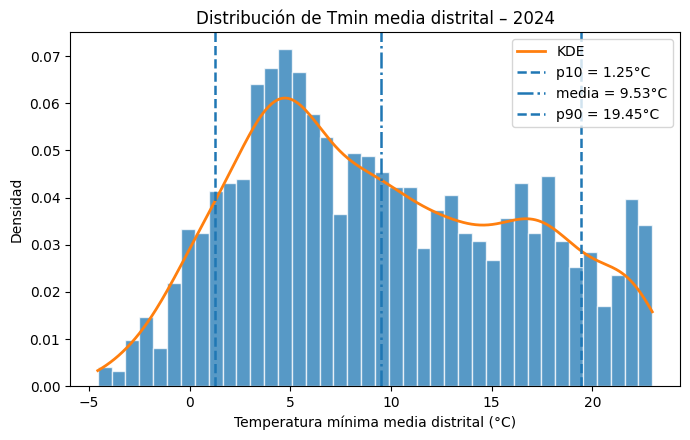

In [25]:
# Año a graficar
year_sel = 2024
df_y = df_zonal[df_zonal["year"] == year_sel].copy()
vals = df_y["mean"].dropna().values

# Estadísticos para anotar
p10 = np.percentile(vals, 10)
mu  = np.mean(vals)
p90 = np.percentile(vals, 90)

plt.figure(figsize=(7,4.5))

# 1) HISTOGRAMA en modo "densidad" para compararlo 1:1 con la KDE
#    (área total ≈ 1 en ambos)
n, bins, patches = plt.hist(vals, bins=40, density=True, alpha=0.75, edgecolor="white")

# 2) KDE (curva de densidad suavizada)
try:
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(vals)                     # bandwidth por defecto (Scott)
    xs = np.linspace(vals.min(), vals.max(), 400)
    plt.plot(xs, kde(xs), linewidth=2, label="KDE")
except Exception:
    pass

# 3) Líneas verticales: p10, media, p90
plt.axvline(p10, linestyle="--", linewidth=1.8, label=f"p10 = {p10:.2f}°C")
plt.axvline(mu,  linestyle="-.", linewidth=1.8, label=f"media = {mu:.2f}°C")
plt.axvline(p90, linestyle="--", linewidth=1.8, label=f"p90 = {p90:.2f}°C")

plt.xlabel("Temperatura mínima media distrital (°C)")
plt.ylabel("Densidad")
plt.title(f"Distribución de Tmin media distrital – {year_sel}")
plt.legend()
plt.tight_layout()
plt.show()

- La mayoría de distritos del país son de temperatura media-baja: alrededor de los 9.53 °C
- Hay distritos cuya temperatura mínima promedio están por encima de los 20° C. Probablemente sean de la selva.
- Los distritos más frío del país tienen temperatura mínima promedio menor a 1.25° C.Probablemente son distritos del altiplano.


#### 3.2. Ranking: Top-15 más fríos (riesgo heladas) y Top-15 más cálidos

In [29]:
# columnas territoriales disponibles
cols_id = [c for c in ["DEPARTAMEN","PROVINCIA","DISTRITO","NOMBRE"] if c in df_zonal.columns]

# ordenar por 'mean'
cold15 = (df_y.sort_values("mean").loc[:, cols_id + ["mean","min","percentile_10","percentile_90","max","std"]].head(15))
warm15 = (df_y.sort_values("mean", ascending=False).loc[:, cols_id + ["mean","min","percentile_10","percentile_90","max","std"]].head(15))

display(cold15)
display(warm15)

# Guardar los CSV para la app
cold_csv = f"../app/ranking_top15_frio_{year_sel}.csv"
warm_csv = f"../app/ranking_top15_calor_{year_sel}.csv"

cold15.to_csv(cold_csv, index=False, encoding="utf-8")
warm15.to_csv(warm_csv, index=False, encoding="utf-8")

print("Guardados:", cold_csv, "y", warm_csv)


,DEPARTAMEN,PROVINCIA,DISTRITO,mean,min,percentile_10,percentile_90,max,std
7541,TACNA,TARATA,TARATA,-4.561076,-6.468026,-6.175215,-3.388719,5.581133,2.829068
7552,PUNO,EL COLLAO,CAPAZO,-4.560061,-6.613354,-5.652370,-3.202446,-2.628129,0.977825
7571,PUNO,EL COLLAO,SANTA ROSA,-4.197036,-7.580888,-6.378613,-2.484949,-1.978441,1.417075
7548,TACNA,TARATA,SUSAPAYA,-4.182688,-7.479485,-7.122831,-0.255336,3.157607,3.119703
7655,AREQUIPA,CAYLLOMA,SAN ANTONIO DE CHUCA,-4.096959,-5.785328,-5.024673,-3.261164,-2.268047,0.714200
8293,CUSCO,ESPINAR,CONDOROMA,-3.855525,-4.881903,-4.474339,-3.004616,-1.324180,0.790883
7543,TACNA,TARATA,TICACO,-3.745632,-5.706429,-5.661110,0.881710,2.511680,2.641085
8017,PUNO,LAMPA,PARATIA,-3.724841,-4.469860,-4.328072,-3.002615,-2.442494,0.529954
7553,TACNA,CANDARAVE,CANDARAVE,-3.715401,-7.204840,-6.199082,1.854045,7.017014,3.551047
7575,MOQUEGUA,MARISCAL NIETO,CARUMAS,-3.053063,-6.169868,-5.585243,3.935331,11.807583,4.463386


,DEPARTAMEN,PROVINCIA,DISTRITO,mean,min,percentile_10,percentile_90,max,std
9327,LORETO,PUTUMAYO,YAGUAS,22.973618,22.780083,22.854121,23.103278,23.226206,0.091803
9172,LORETO,DATEM DEL MARAÑON,MORONA,22.952683,20.953283,22.668024,23.238250,23.388550,0.334675
9168,LORETO,MARISCAL RAMON CASTILLA,RAMON CASTILLA,22.926581,22.814796,22.859756,22.986374,23.050581,0.048974
9167,LORETO,MARISCAL RAMON CASTILLA,SAN PABLO,22.887480,22.713934,22.803846,22.963652,23.012863,0.063301
9169,LORETO,DATEM DEL MARAÑON,PASTAZA,22.870794,22.581930,22.721573,23.020864,23.635798,0.145837
9171,LORETO,MARISCAL RAMON CASTILLA,PEBAS,22.836467,22.665327,22.760663,22.909175,22.993376,0.059887
9170,LORETO,MAYNAS,LAS AMAZONAS,22.762101,22.564980,22.656764,22.856007,22.948288,0.075826
8172,LORETO,PUTUMAYO,PUTUMAYO,22.742786,22.473694,22.568569,22.931459,23.055101,0.133731
8052,LORETO,MAYNAS,IQUITOS,22.722595,22.564741,22.594120,22.793990,22.847094,0.079448
9157,TUMBES,ZARUMILLA,AGUAS VERDES,22.709639,22.709639,22.709639,22.709639,22.709639,0.000000


Guardados: ../app/ranking_top15_frio_2024.csv y ../app/ranking_top15_calor_2024.csv


#### 3.3. Mapa coroplético estático de mean Tmin

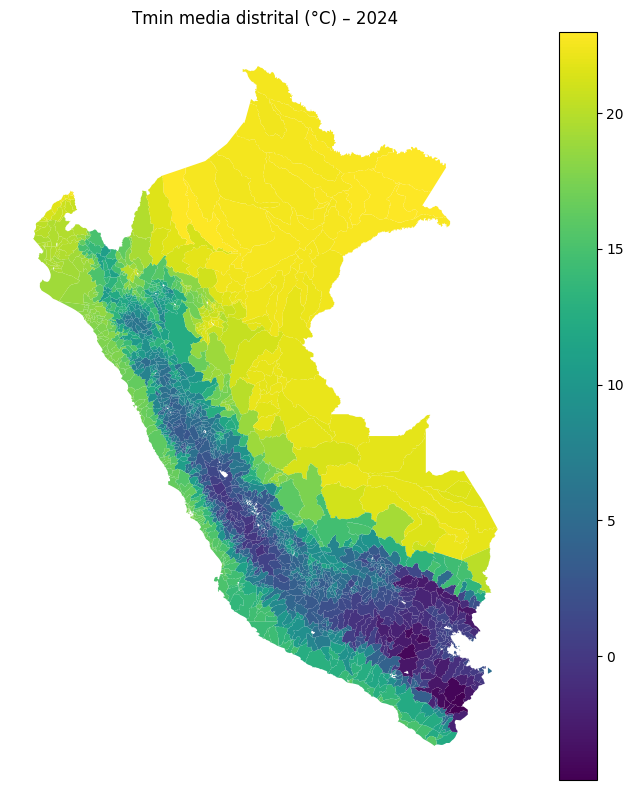

✅ Mapa guardado en: ../app/static_map_2024.png
✅ Tabla descargable guardada en: ../app/tabla_mapa_tmin_2024.csv
Umbrales 2024 — p10=1.25°C, p90=19.45°C


,DEPARTAMEN,PROVINCIA,DISTRITO,mean,min,max,std,amplitud_p90_p10,CLASE_P10_P90
7492,HUANUCO,PUERTO INCA,CODO DEL POZUZO,18.754149,9.002318,22.482599,3.358801,8.404143,INTERMEDIO (p10–p90)
7493,HUANUCO,PUERTO INCA,TOURNAVISTA,22.099378,19.724146,22.625916,0.434192,0.649906,CÁLIDO (≥ p90)
7494,UCAYALI,PADRE ABAD,ALEXANDER VON HUMBOLDT,21.840640,21.680176,21.938402,0.088975,0.198318,CÁLIDO (≥ p90)
7495,UCAYALI,PADRE ABAD,IRAZOLA,22.071029,21.441895,22.329485,0.162780,0.383223,CÁLIDO (≥ p90)
7496,UCAYALI,PADRE ABAD,NESHUYA,21.878135,21.649612,22.137220,0.147724,0.392431,CÁLIDO (≥ p90)


In [32]:
# --- 1) Filtrar año y preparar columnas ---
df_y = df_zonal[df_zonal["year"] == year_sel].copy()
cols_id = [c for c in ["DEPARTAMEN","PROVINCIA","DISTRITO","NOMBRE"] if c in df_zonal.columns]
req_cols = cols_id + [c for c in ["mean","min","max","std","p10","p90","amplitud_p90_p10"] if c in df_zonal.columns]
df_map = df_y[req_cols].copy()

# --- 2) (Opcional) Clasificación por percentiles globales del año ---
p10_glob = np.percentile(df_map["mean"].dropna(), 10)
p90_glob = np.percentile(df_map["mean"].dropna(), 90)
def _clas(v):
    if pd.isna(v): return np.nan
    if v <= p10_glob: return "FRÍO (≤ p10)"
    if v >= p90_glob: return "CÁLIDO (≥ p90)"
    return "INTERMEDIO (p10–p90)"
df_map["CLASE_P10_P90"] = df_map["mean"].map(_clas)

# --- 3) Unir al GeoDataFrame (join por nombres normalizados) ---
gmap = gdf.merge(df_map, on=cols_id, how="left")

# --- 4) Plot y PNG para la app ---
fig, ax = plt.subplots(figsize=(8,8))
gmap.plot(column="mean", ax=ax, legend=True, edgecolor="none")
ax.set_title(f"Tmin media distrital (°C) – {year_sel}")
ax.axis("off")
plt.tight_layout()

out_png = f"../app/static_map_{year_sel}.png"
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()

# --- 5) Tabla descargable (CSV) para la app/entrega ---
out_csv = f"../app/tabla_mapa_tmin_{year_sel}.csv"

# Sugerencia de columnas para la tabla pública:
cols_csv = cols_id + ["mean","min","max","std"]
if "p10" in df_map and "p90" in df_map:
    cols_csv += ["p10","p90"]
if "amplitud_p90_p10" in df_map:
    cols_csv += ["amplitud_p90_p10"]
cols_csv += ["CLASE_P10_P90"]

tabla_mapa = df_map[cols_csv].copy()
tabla_mapa.to_csv(out_csv, index=False, encoding="utf-8")

print("✅ Mapa guardado en:", out_png)
print("✅ Tabla descargable guardada en:", out_csv)
print(f"Umbrales {year_sel} — p10={p10_glob:.2f}°C, p90={p90_glob:.2f}°C")
display(tabla_mapa.head())